In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.decomposition import PCA


2024-09-17 21:50:21.896198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 21:50:21.910081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 21:50:21.927205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 21:50:21.931630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 21:50:21.945307: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data = pd.read_csv('/home/vivekup3424/Documents/Projects/python_projects/Games-for-MLP-Training/web_app/game_log.csv')
data = data.drop(columns='closest_body_distance')
# Clean up the last column by removing quotes and converting everything to uppercase
data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: str(x).replace("'", "").upper())
data

,head_x,head_y,tail_x,tail_y,food_x,food_y,direction,snake_length,score,head_top_distance,...,body_turns,moves_since_eating,total_moves,enclosed_spaces_count,largest_enclosed_space,tail_reachable,food_eaten,game_ended,time_elapsed,action
0,16,10,15,10,6,19,1,2,1,10,...,0,45,45,0,0,True,False,False,4.692,UP
1,16,7,16,8,6,19,1,2,1,7,...,0,48,48,0,0,True,False,False,4.970,UP
2,16,3,16,4,6,19,1,2,1,3,...,0,52,52,0,0,True,False,False,5.363,UP
3,16,0,16,1,6,19,1,2,1,0,...,0,55,55,0,0,True,False,False,5.667,UP
4,16,15,16,16,6,19,4,2,1,15,...,0,80,80,0,0,True,False,False,8.108,RIGHT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658,17,13,5,19,17,4,1,19,18,13,...,1,354,354,0,0,True,False,False,37.265,UP
7659,17,3,8,13,0,16,3,20,19,3,...,1,363,363,0,0,True,False,False,38.273,LEFT
7660,19,3,17,4,0,16,1,20,19,3,...,1,381,381,0,0,True,False,False,40.033,UP
7661,19,6,1,3,0,16,3,20,19,6,...,1,398,398,0,0,True,False,False,41.713,LEFT


In [3]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
action_encoded = one_hot_encoder.fit_transform(data[['action']])
action_columns = one_hot_encoder.get_feature_names_out(['action'])
action_encoded_df = pd.DataFrame(action_encoded, columns=action_columns)
action_encoded_df

,action_DOWN,action_LEFT,action_RIGHT,action_UP
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
7658,0.0,0.0,0.0,1.0
7659,0.0,1.0,0.0,0.0
7660,0.0,0.0,0.0,1.0
7661,0.0,1.0,0.0,0.0


In [4]:
data = pd.concat([data.drop(columns=['action']), action_encoded_df], axis=1)

In [5]:
data = data.loc[:, data.nunique() > 1]

In [6]:
X = data.drop(columns=action_columns)  # Features without the one-hot encoded 'action' columns
y = data[action_columns]  # The target is the one-hot encoded 'action' columns
y

,action_DOWN,action_LEFT,action_RIGHT,action_UP
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
7658,0.0,0.0,0.0,1.0
7659,0.0,1.0,0.0,0.0
7660,0.0,0.0,0.0,1.0
7661,0.0,1.0,0.0,0.0


In [7]:
first_rows = np.array(X.iloc[0])
categorical_cols = []

# Identify numeric columns
numeric_cols = []

for i in range(len(first_rows)-1):
    if(type(first_rows[i]) == str or type(first_rows[i])== np.bool_):
        print(type(first_rows[i]))
        categorical_cols.append(i)
    else:
        numeric_cols.append(i)

categorical_cols
for i in categorical_cols:
    print(first_rows[i])



<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
False
False
True
False
False
True
True
False


In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df

,head_x,head_y,tail_x,tail_y,food_x,food_y,direction,snake_length,score,head_top_distance,...,food_above,food_below,food_left,food_right,body_segments_same_row,body_segments_same_column,body_turns,moves_since_eating,total_moves,time_elapsed
0,0.842105,0.526316,0.789474,0.526316,0.315789,1.000000,0.000000,0.012987,0.012987,0.526316,...,0.0,1.0,1.0,0.0,0.052632,0.000000,0.000000,0.012600,0.012600,0.012656
1,0.842105,0.368421,0.842105,0.421053,0.315789,1.000000,0.000000,0.012987,0.012987,0.368421,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.013522,0.013522,0.013491
2,0.842105,0.157895,0.842105,0.210526,0.315789,1.000000,0.000000,0.012987,0.012987,0.157895,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.014751,0.014751,0.014671
3,0.842105,0.000000,0.842105,0.052632,0.315789,1.000000,0.000000,0.012987,0.012987,0.000000,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.015673,0.015673,0.015583
4,0.842105,0.789474,0.842105,0.842105,0.315789,1.000000,1.000000,0.012987,0.012987,0.789474,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.023356,0.023356,0.022913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658,0.894737,0.684211,0.263158,1.000000,0.894737,0.210526,0.000000,0.233766,0.233766,0.684211,...,1.0,0.0,0.0,0.0,0.631579,0.000000,0.083333,0.107560,0.107560,0.110458
7659,0.894737,0.157895,0.421053,0.684211,0.000000,0.842105,0.666667,0.246753,0.246753,0.157895,...,0.0,1.0,1.0,0.0,0.000000,0.526316,0.083333,0.110326,0.110326,0.113485
7660,1.000000,0.157895,0.894737,0.210526,0.000000,0.842105,0.000000,0.246753,0.246753,0.157895,...,0.0,1.0,1.0,0.0,0.947368,0.000000,0.083333,0.115857,0.115857,0.118769
7661,1.000000,0.315789,0.052632,0.157895,0.000000,0.842105,0.666667,0.246753,0.246753,0.315789,...,0.0,1.0,1.0,0.0,0.000000,0.894737,0.083333,0.121082,0.121082,0.123814


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
y_test

(6130, 33)
(1533, 33)
(6130, 4)
(1533, 4)


,action_DOWN,action_LEFT,action_RIGHT,action_UP
3298,0.0,1.0,0.0,0.0
2473,0.0,1.0,0.0,0.0
800,0.0,1.0,0.0,0.0
2641,0.0,0.0,0.0,1.0
1407,0.0,1.0,0.0,0.0
...,...,...,...,...
1616,0.0,0.0,0.0,1.0
6687,1.0,0.0,0.0,0.0
2697,1.0,0.0,0.0,0.0
7121,0.0,1.0,0.0,0.0


In [11]:
# Define the neural network model
model = Sequential([
    Dense(20, activation='relu',input_dim = X_train.shape[1]),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=130, validation_split=0.1)

/home/vivekup3424/Documents/Projects/python_projects/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1726590025.384523  243845 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-17 21:50:25.445276: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the r

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2395 - loss: 1.4663 - val_accuracy: 0.4535 - val_loss: 1.3127
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4787 - loss: 1.2785 - val_accuracy: 0.5759 - val_loss: 1.1261
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6348 - loss: 1.0600 - val_accuracy: 0.8434 - val_loss: 0.8135
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8543 - loss: 0.7526 - val_accuracy: 0.8842 - val_loss: 0.5466
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8741 - loss: 0.5175 - val_accuracy: 0.8907 - val_loss: 0.4142
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8801 - loss: 0.4036 - val_accuracy: 0.8891 - val_loss: 0.3594
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8862 - loss: 0.3563 - val_accuracy: 0.8891 - val_loss: 0.3309
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8769 - loss: 0.3463 - val_accuracy: 0.8907 - val_loss

In [12]:
y_train

,action_DOWN,action_LEFT,action_RIGHT,action_UP
1652,1.0,0.0,0.0,0.0
3194,0.0,0.0,1.0,0.0
6009,0.0,1.0,0.0,0.0
1192,0.0,0.0,0.0,1.0
4582,0.0,0.0,1.0,0.0
...,...,...,...,...
5226,0.0,1.0,0.0,0.0
5390,0.0,0.0,0.0,1.0
860,0.0,0.0,1.0,0.0
7603,0.0,0.0,0.0,1.0


In [16]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.values, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)

# Ensure there are no NaNs
if np.isnan(y_test.values).any() or np.isnan(y_pred).any():
    raise ValueError("Input contains NaN.")

# Calculate R² score
r2 = r2_score(y_test.values, y_pred, multioutput='uniform_average')

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'R² Score: {r2:.2f}')

# Print detailed classification report
print("Performance Metrics:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['DOWN', 'LEFT', 'RIGHT', 'UP']))



48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
R² Score: 0.96
Performance Metrics:
              precision    recall  f1-score   support

        DOWN       0.99      0.99      0.99       389
        LEFT       0.97      0.99      0.98       377
       RIGHT       1.00      0.98      0.99       379
          UP       0.99      1.00      1.00       388

    accuracy                           0.99      1533
   macro avg       0.99      0.99      0.99      1533
weighted avg       0.99      0.99      0.99      1533



In [14]:
y_train

,action_DOWN,action_LEFT,action_RIGHT,action_UP
1652,1.0,0.0,0.0,0.0
3194,0.0,0.0,1.0,0.0
6009,0.0,1.0,0.0,0.0
1192,0.0,0.0,0.0,1.0
4582,0.0,0.0,1.0,0.0
...,...,...,...,...
5226,0.0,1.0,0.0,0.0
5390,0.0,0.0,0.0,1.0
860,0.0,0.0,1.0,0.0
7603,0.0,0.0,0.0,1.0


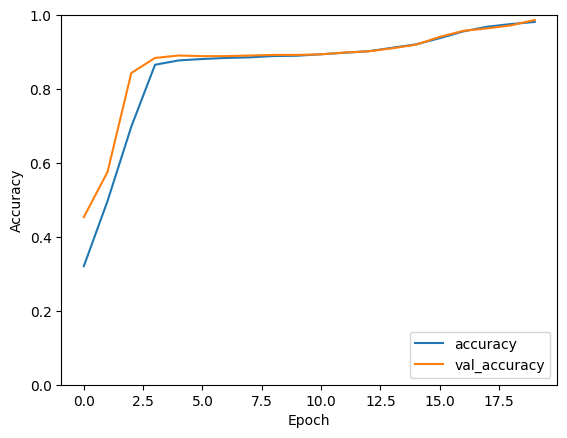

In [15]:
# Plot training history if needed
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()